## Final Project: Simulation and Evaluation of the BB84 Quantum Key Distribution Protocol

### Group Members: 
#### **- Ayawa  Sidoinette SOWOU - asx33@hi.is**
#### **- Silja Rós Svansdóttir Þormar - srs60@hi.is**

In [21]:
%matplotlib inline

In [13]:
# === Imports and Requirements ===
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator, Aer
from qiskit.quantum_info import Statevector
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# For nicer plotting
plt.rcParams.update({'figure.max_open_warning': 0})

# ##  Parameters
# Adjust these before running the simulation cells.

# Simulation parameters
NUM_QUBITS = 100            # number of qubits per trial
EAVESDROP_PROBS = [0.0, 0.1, 0.2, 0.3, 0.5]  # probabilities of Eve intercepting
NOISE_PROB = 0.05           # per-qubit random Pauli error probability for channel
TRIALS_PER_POINT = 20       # number of trials per eavesdrop prob (for averaging)

# Backend 
BACKEND = AerSimulator()

### 1. Core BB84 Protocol Implementation

In [14]:
class BB84Protocol:
    def __init__(self, num_qubits=50, backend=None):
        self.num_qubits = num_qubits
        self.backend = BACKEND or AerSimulator()

    def generate_random_bits(self, length):
        return [random.randint(0, 1) for _ in range(length)]

    def prepare_qubits(self, bits, bases):
        """Alice prepares qubits based on her bits and bases.
        Returns a list of single-qubit QuantumCircuit objects.
        """
        circuits = []
        for i in range(len(bits)):
            qc = QuantumCircuit(1, 1)

            # Prepare |1> if bit==1
            if bits[i] == 1:
                qc.x(0)

            # If diagonal basis (X-basis), apply H to prepare |+> or |->
            if bases[i] == 1:  # X-basis
                qc.h(0)

            circuits.append(qc)
        return circuits

    def measure_qubits(self, circuits, bases):
        """Bob measures qubits in his chosen bases.
        Executes each single-qubit circuit with shots=1 and returns measured bits.
        """
        results = []
        measured_circuits = []

        for i, qc in enumerate(circuits):
            measured_qc = qc.copy()

            # If Bob measures in X-basis, apply H before measurement
            if bases[i] == 1:
                measured_qc.h(0)

            measured_qc.measure(0, 0)
            measured_circuits.append(measured_qc)

            # Execute measurement
            job = self.backend.run(measured_qc, shots=1)
            result = job.result()
            counts = result.get_counts()
            measured_bit = int(list(counts.keys())[0])
            results.append(measured_bit)

        return results, measured_circuits

    def sift_key(self, alice_bits, bob_bits, alice_bases, bob_bases):
        sifted_alice = []
        sifted_bob = []
        sifted_indices = []
        for i in range(len(alice_bits)):
            if alice_bases[i] == bob_bases[i]:
                sifted_alice.append(alice_bits[i])
                sifted_bob.append(bob_bits[i])
                sifted_indices.append(i)
        return sifted_alice, sifted_bob, sifted_indices

    def compute_qber(self, sifted_alice, sifted_bob):
        if not sifted_alice:
            return 0.0
        errors = sum(1 for a, b in zip(sifted_alice, sifted_bob) if a != b)
        return errors / len(sifted_alice)

### 2. Eavesdropping Implementation

In [15]:
class Eavesdropper:
    def __init__(self, intercept_probability=0.3, backend=None):
        self.intercept_probability = intercept_probability
        self.backend = BACKEND or AerSimulator()

    def intercept_resend_attack(self, circuits):
        """Eve intercepts some qubits and resends measured results.
        Returns a new list of circuits (the ones sent onward).
        """
        intercepted_circuits = []

        for qc in circuits:
            if random.random() < self.intercept_probability:
                # Eve intercepts this qubit
                eve_basis = random.randint(0, 1)  # choose Z (0) or X (1)

                # Copy the circuit so Eve doesn't break the original
                eve_qc = qc.copy()

                # Measure in Eve's basis
                if eve_basis == 1:
                    eve_qc.h(0)
                eve_qc.measure(0, 0)

                job = self.backend.run(eve_qc, shots=1)
                result = job.result()
                counts = result.get_counts()
                eve_bit = int(list(counts.keys())[0])

                # Prepare a new qubit according to Eve's measurement and basis
                new_qc = QuantumCircuit(1, 1)
                if eve_bit == 1:
                    new_qc.x(0)
                if eve_basis == 1:
                    new_qc.h(0)

                intercepted_circuits.append(new_qc)
            else:
                 # No interception
                intercepted_circuits.append(qc.copy())

        return intercepted_circuits


####  Noise Model
This simple function injects random Pauli errors into transmitted qubits to
emulate an imperfect channel. You can replace this with Qiskit's noise model
for more realistic hardware-like noise, but this is sufficient for the project.

In [16]:
def add_quantum_noise(circuits, error_prob=0.05):
    """Add simple Pauli noise to some qubits with probability error_prob."""
    noisy_circuits = []
    for qc in circuits:
        noisy_qc = qc.copy()
        if random.random() < error_prob:
            error_type = random.choice(['x', 'y', 'z'])
            if error_type == 'x':
                noisy_qc.x(0)
            elif error_type == 'y':
                noisy_qc.y(0)
            else:
                noisy_qc.z(0)
        noisy_circuits.append(noisy_qc)
    return noisy_circuits

### 3. Complete Protocol with Analysis
The analyzer runs multiple trials, stores results, and provides plotting utilities.

In [17]:
class QKDAnalyzer:
    def __init__(self, backend=None):
        self.results_history = []
        self.backend = BACKEND or AerSimulator()

    def run_bb84_simulation(self, num_qubits=50, eavesdrop_prob=0.0, noise_prob=0.0):
        # Initialize protocol
        bb84 = BB84Protocol(num_qubits, backend=self.backend)

        # Step 1: Alice generates random bits and bases
        alice_bits = bb84.generate_random_bits(num_qubits)
        alice_bases = bb84.generate_random_bits(num_qubits)

        # Step 2: Alice prepares qubits
        qubits = bb84.prepare_qubits(alice_bits, alice_bases)

        # Step 2.5: Channel noise
        if noise_prob > 0:
            qubits = add_quantum_noise(qubits, error_prob=noise_prob)

        # Step 3: Eavesdropping (if any)
        if eavesdrop_prob > 0:
            eve = Eavesdropper(eavesdrop_prob, backend=self.backend)
            qubits = eve.intercept_resend_attack(qubits)

        # Step 4: Bob measures
        bob_bases = bb84.generate_random_bits(num_qubits)
        bob_bits, measured_circuits = bb84.measure_qubits(qubits, bob_bases)

        # Step 5: Basis reconciliation (sifting)
        sifted_alice_bits, sifted_bob_bits, sifted_indices = bb84.sift_key(
            alice_bits, bob_bits, alice_bases, bob_bases
        )

        # Step 6: Error rate calculation
        qber = bb84.compute_qber(sifted_alice_bits, sifted_bob_bits)

        # Calculate metrics
        sifted_key_rate = len(sifted_indices) / num_qubits
        # Protocol efficiency: fraction of sifted bits that match (1 - QBER)
        protocol_efficiency = 1 - qber

        result = {
            'num_qubits': num_qubits,
            'eavesdrop_prob': eavesdrop_prob,
            'noise_prob': noise_prob,
            'qber': qber,
            'sifted_key_rate': sifted_key_rate,
            'protocol_efficiency': protocol_efficiency,
            'sifted_key_length': len(sifted_indices),
            'alice_bits': alice_bits,
            'bob_bits': bob_bits,
            'sifted_alice_bits': sifted_alice_bits,
            'sifted_bob_bits': sifted_bob_bits
        }

        self.results_history.append(result)
        return result

### 4. Visualization and Analysis


In [18]:
# Plotting function
def plot_results(analyzer):
    results_df = pd.DataFrame(analyzer.results_history)

    # If no results, do nothing
    if results_df.empty:
        print("No results to plot.")
        return

    grouped = results_df.groupby(['eavesdrop_prob', 'noise_prob']).agg({'qber': 'mean',
                                                                        'sifted_key_rate': 'mean',
                                                                        'protocol_efficiency': 'mean',
                                                                        'sifted_key_length': 'mean'}).reset_index()

    # Unique eavesdrop probs and noise probs
    e_probs = sorted(grouped['eavesdrop_prob'].unique())
    n_probs = sorted(grouped['noise_prob'].unique())

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    ax1, ax2, ax3, ax4 = axes.flatten()

    # QBER vs Eavesdropping for each noise level
    for noise in n_probs:
        subset = grouped[grouped['noise_prob'] == noise]
        ax1.plot(subset['eavesdrop_prob'], subset['qber'], marker='o', label=f'noise={noise}')
    ax1.set_xlabel('Eavesdropping Probability')
    ax1.set_ylabel('QBER')
    ax1.set_title('QBER vs Eavesdropping (per noise level)')
    ax1.legend()
    ax1.grid(True)

    # Sifted key rate vs Eavesdropping
    for noise in n_probs:
        subset = grouped[grouped['noise_prob'] == noise]
        ax2.plot(subset['eavesdrop_prob'], subset['sifted_key_rate'], marker='o', label=f'noise={noise}')
    ax2.set_xlabel('Eavesdropping Probability')
    ax2.set_ylabel('Sifted Key Rate')
    ax2.set_title('Sifted Key Rate vs Eavesdropping')
    ax2.legend()
    ax2.grid(True)

    # Protocol efficiency vs Eavesdropping
    for noise in n_probs:
        subset = grouped[grouped['noise_prob'] == noise]
        ax3.plot(subset['eavesdrop_prob'], subset['protocol_efficiency'], marker='o', label=f'noise={noise}')
    ax3.set_xlabel('Eavesdropping Probability')
    ax3.set_ylabel('Protocol Efficiency (1 - QBER)')
    ax3.set_title('Protocol Efficiency vs Eavesdropping')
    ax3.legend()
    ax3.grid(True)

    # Distribution of sifted key lengths
    ax4.hist(results_df['sifted_key_length'], bins=15, edgecolor='black')
    ax4.set_xlabel('Sifted Key Length')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Distribution of Sifted Key Lengths')

    plt.tight_layout()
    plt.show()


### 5. Educational Demonstrations

In [22]:
# A short cell explaining superposition, no-cloning, and basis mismatch. These are
# printouts / small circuits to help teach the principles.

from qiskit.visualization import plot_histogram


def demonstrate_quantum_principles():
    print("=== Quantum Principles Demonstration ===\n")

    # Superposition example
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.measure(0, 0)
    job = execute(qc, BACKEND, shots=1024)
    counts = job.result().get_counts()

    print("1) Superposition (H on |0>): expected ~50/50 measurement results")
    display(plot_histogram(counts))

    # No-cloning - explanation only
    print("\n2) No-Cloning Theorem: cannot copy an unknown quantum state.")
    print("   Intercept-resend attacks necessarily disturb the state and introduce errors.")

    # Basis mismatch demonstration
    print("\n3) Basis Mismatch: Alice sends |0> but Bob measures in X-basis -> 50/50")
    qc2 = QuantumCircuit(1, 1)
    # Alice prepares |0> explicitly (nothing)
    # Bob measures in X basis
    qc2.h(0)
    qc2.measure(0, 0)
    job = execute(qc2, BACKEND, shots=1024)
    counts2 = job.result().get_counts()
    plot_histogram(counts2)


### 6. Run Simulations (multi-trial)
This cell runs the multi-trial experiments using the parameters above.
It will take longer depending on NUM_QUBITS and TRIALS_PER_POINT.

Simulation complete. Summary (first rows):
                               qber  sifted_key_length
eavesdrop_prob noise_prob                             
0.0            0.00        0.000000              50.45
               0.05        0.030470              48.20
0.1            0.00        0.019018              50.35
               0.05        0.063216              48.90
0.2            0.00        0.043432              50.65


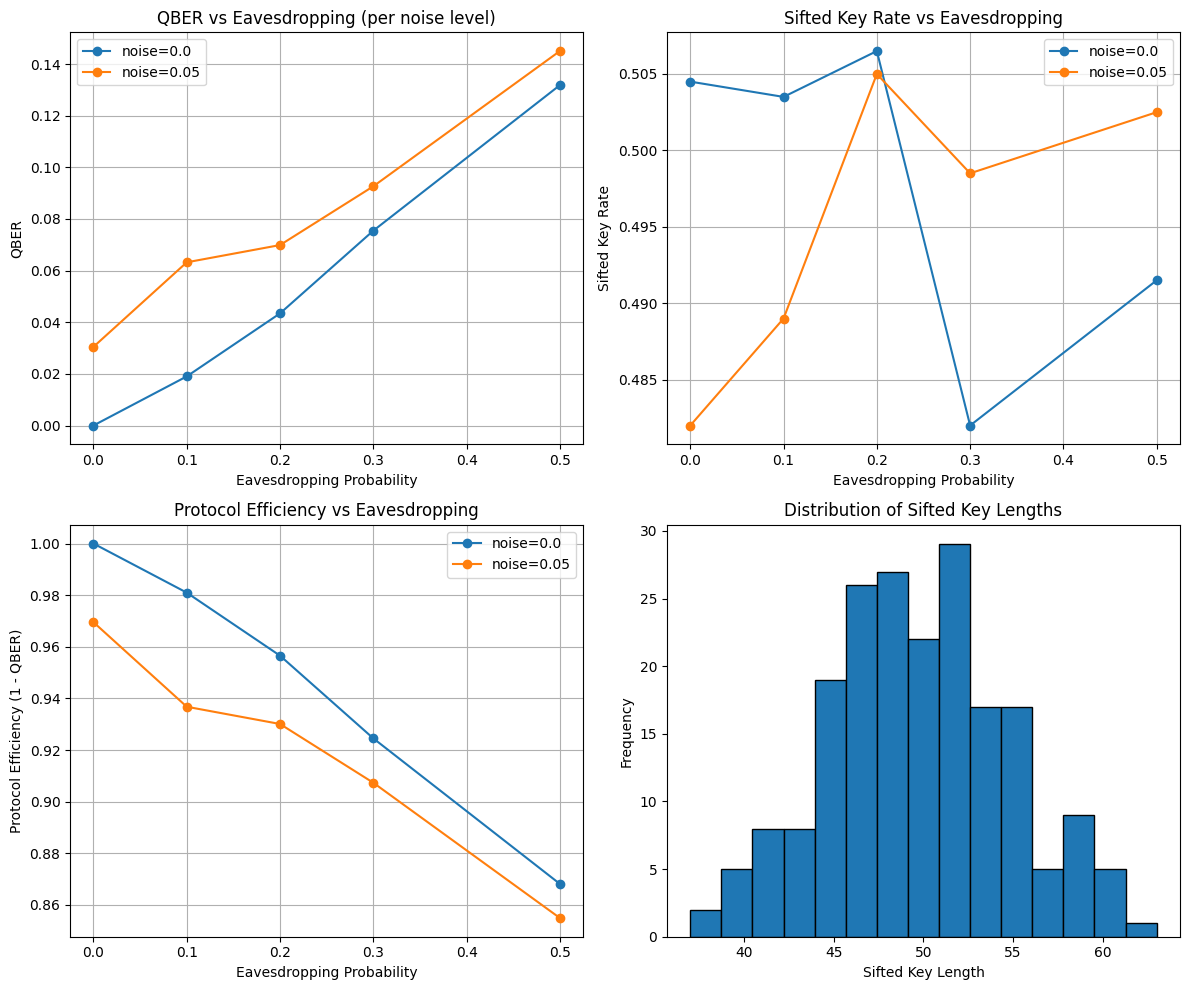

In [23]:
# Create analyzer
analyzer = QKDAnalyzer(backend=BACKEND)

# Run multi-trial experiments
for noise in [0.0, NOISE_PROB]:
    for p in EAVESDROP_PROBS:
        for _ in range(TRIALS_PER_POINT):
            res = analyzer.run_bb84_simulation(num_qubits=NUM_QUBITS,
                                              eavesdrop_prob=p,
                                              noise_prob=noise)

# Quick summary printout
summary_df = pd.DataFrame(analyzer.results_history)
print("Simulation complete. Summary (first rows):")
print(summary_df.groupby(['eavesdrop_prob','noise_prob']).agg({'qber':'mean','sifted_key_length':'mean'}).head())


# Visualize Results
plot_results(analyzer)

#### Sample key generation output (no eavesdropping, no noise)

In [24]:
# Display a short sample of sifted bits to show keys and whether they match.
no_eve_no_noise = [r for r in analyzer.results_history if r['eavesdrop_prob'] == 0 and r['noise_prob'] == 0][0]
print("Alice sifted (sample):", no_eve_no_noise['sifted_alice_bits'][:30])
print("Bob   sifted (sample):", no_eve_no_noise['sifted_bob_bits'][:30])
print("Match?", no_eve_no_noise['sifted_alice_bits'] == no_eve_no_noise['sifted_bob_bits'])


Alice sifted (sample): [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0]
Bob   sifted (sample): [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0]
Match? True


#### Optional: Final key extraction (simple demonstration)

In [25]:
# We perform a trivial privacy amplification by discarding half the sifted bits
# used for parameter estimation and taking the remainder as the final key (demo only).

sample = no_eve_no_noise['sifted_alice_bits']
if len(sample) >= 10:
    # Use first 25% for testing, remaining for key
    split = max(1, len(sample)//4)
    test = sample[:split]
    final_key = sample[split:]
    print(f"Used {split} bits for parameter check; final key length = {len(final_key)}")
    print("Final key (sample):", final_key[:30])
else:
    print("Not enough sifted bits to demonstrate key extraction in this sample.")

Used 13 bits for parameter check; final key length = 42
Final key (sample): [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]


###  Notes & Next Steps
- We can increase `TRIALS_PER_POINT` for smoother plots (longer runtime).
- Replace `add_quantum_noise` with Qiskit's `NoiseModel` for hardware-like errors.
- Consider adding timing measurements and small runs on IBM hardware to compare.

### Real Hardware Integration

In [ ]:
def run_on_real_hardware(circuits, backend_name):
    """Run on actual IBM quantum hardware"""
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider()
    backend = provider.get_backend(backend_name)
    
    # Would need to adapt circuits for real hardware constraints
    # (coupling map, basis gates, etc.)
    return backend